# LiFT version in OOPAO
- Notebook with some examples of usage

In [1]:
# general imports
import numpy as np
import matplotlib.pyplot as plt

# OOPAO imports
from OOPAO.Source import Source
from OOPAO.Telescope import Telescope
from OOPAO.Zernike import Zernike
from OOPAO.Detector import Detector

# import LiFT
from OOPAO.LiFT import LiFT
from OOPAO.tools.tools import crop



   ✸       *          °          *      *                                      
        °   ✸         ▄██▄   ▄██▄  ▄███▄   ▄██▄ * ▄██▄    >           ▄▄▄▄     
  ✸            °     ██* ██ ██  ██ ██  ██ ██  ██ ██  ██   ===>     ▄█▀▀  ▀▀█▄  
   *   °    ✸        ██  ██ ██° ██ ██  ██ ██* ██ ██  ██   =>      █▀ ▄█▀▀█▄ ▀█ 
✸    *           °   ██  ██ ██  ██ ████▀  ██▄▄██ ██  ██   ====>  █▀ █▀ ▄▄ ▀█ ▀█
           ✸   °     ██* ██ ██  ██ ██     ██▀▀██ ██  ██   =====> █▄ █▄ ▀▀ ▄█ ▄█
 *    ✸     °        ██  ██ ██  ██ ██ *   ██  ██ ██* ██   =>      █▄ ▀█▄▄█▀ ▄█ 
    °        *    ✸   ▀██▀   ▀██▀  ██   ° ██  ██  ▀██▀    ==       ▀█▄▄  ▄▄█▀  
         ✸       *        *         *                                 ▀▀▀▀     


CuPy is not found, using NumPy backend...
CuPy is not found, using NumPy backend...


## Create telescope, source and detector objects

In [2]:
# create the Telescope object
tel = Telescope(resolution = 128, diameter = 10, centralObstruction = 0, samplingTime=5e-3)

# Source
src = Source(optBand = 'H', magnitude = 14)
src*tel

# Zernike base
nModes = 50  # number of zernike to compute

#create a zernike object
Z = Zernike(telObject = tel, J = nModes)

# compute the zernike polynomials associated with the telescope tel
Z.computeZernike(tel)

det = Detector(readoutNoise=4,photonNoise=True)

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% TELESCOPE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
     Diameter             10               [m]        
    Resolution           128             [pixels]     
    Pixel Size           0.08              [m]        
     Surface             79.0              [m2]       
Central Obstruction        0          [% of diameter]  
Pixels in the pupil      12892            [pixels]     
  Field of View           0              [arcsec]     
      Source             None                         
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
No light propagated through the telescope
%%%%%%%%%%%%%%%%%%%%%%%%%%%%% SOURCE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
 Source Wavelength Zenith  Azimuth   Altitude Magnitude    Flux   
           [m]    [arcsec]  [deg]      [m]              [phot/m2/s]
-------------------------------------------------------------------
  NGS   1.654e-06    0        0        inf    14.000000000000002  7508.4  
%%%%%%%%%%%%%%%%%%%%%%%%

## Test detector

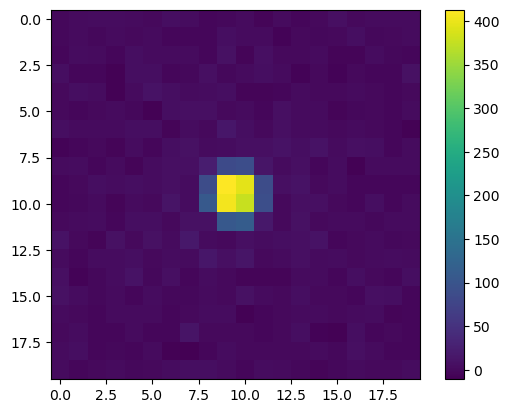

In [3]:
det.readoutNoise = 4
det.phtonNoise = True

#det.integrationTime=10*tel.samplingTime

src*tel*det

plt.imshow(crop(tel.PSF,20,axis=0))
plt.colorbar()
plt.show()

## LiFT - Without noise

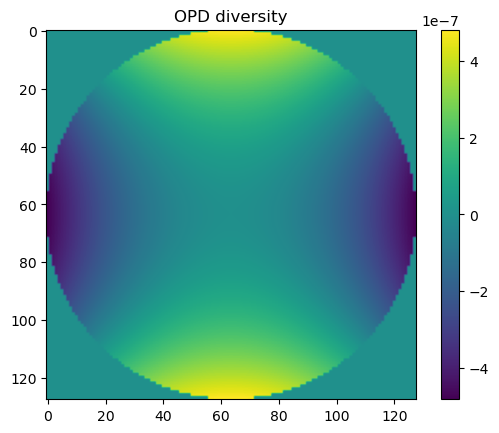

Using detector PSF sampling:2.0 Pixels/FWHM 


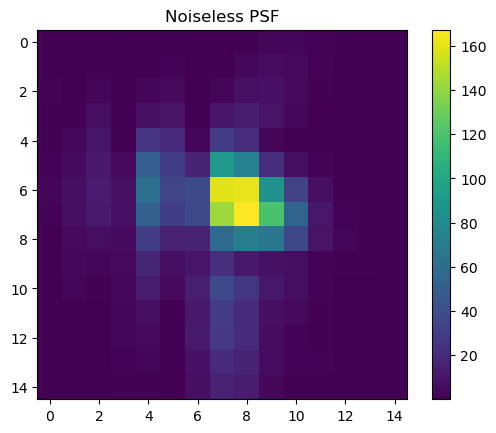

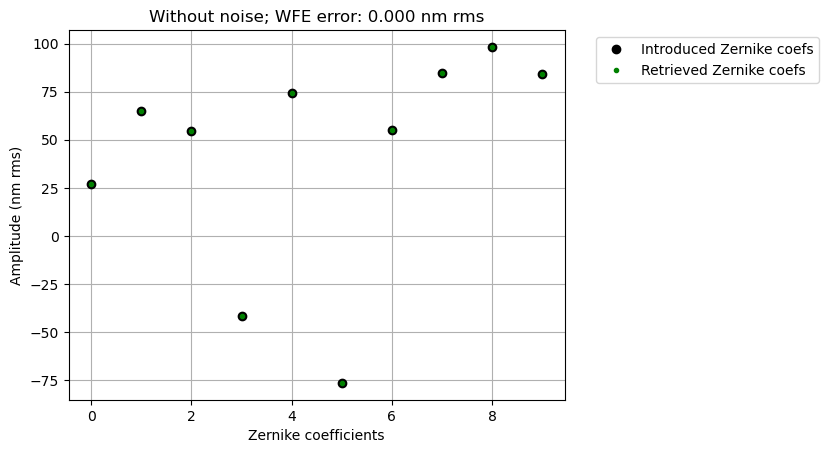

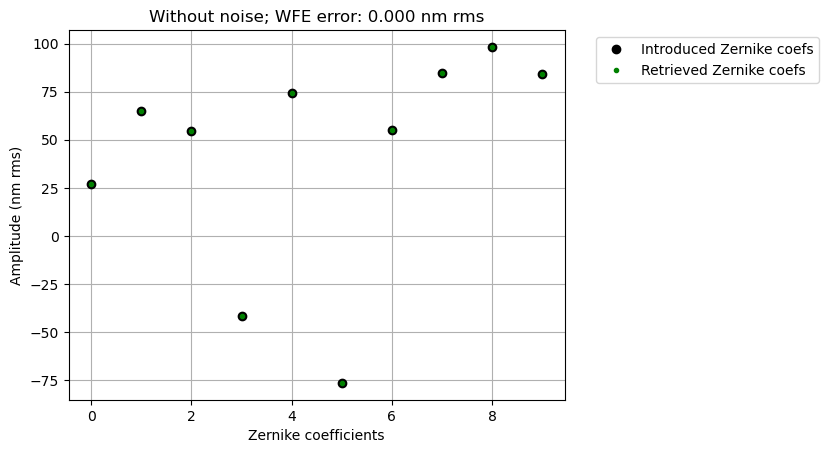

In [6]:
amp_diversity = np.zeros(nModes)
amp_diversity[4] = 200e-9       # 200 nm rms of astigmatism (0º) as phase diversity

diversity_OPD = np.squeeze(Z.modesFullRes@amp_diversity)

plt.imshow(diversity_OPD)
plt.title("OPD diversity")
plt.colorbar()
plt.show()

# using detector sampling
estimator = LiFT(tel = tel, basis = Z.modesFullRes, det = det, diversity_OPD = diversity_OPD,iterations = 20,
                 img_resolution = 15, numerical=False)

## specifying the size of the pixels in arcsec:
#estimator = LiFT(tel = tel, basis = Z.modesFullRes, det = det, diversity_OPD = diversity_OPD,iterations = 20,
#                  ang_pixel_arcsec = 20e-3, img_resolution = 15, numerical=False)

# iterations: maximum number of iterations allowed for LiFT algorithm
# ang_pixel: pixel angular size of the detector in mas
# img_resolution: image resolution of the detector

def PSFfromCoefs(coefs,diversity_OPD):

    OPD = np.squeeze(Z.modesFullRes@coefs)
    tel.OPD = OPD + diversity_OPD
    k = 2*np.pi/(tel.src.wavelength)
    # PSF = estimator.PropagateField(amplitude = np.sqrt(tel.src.fluxMap), phase = k*tel.OPD, return_intensity=True)
    tel.PropagateField(amplitude = np.sqrt(tel.src.fluxMap), phase = k*tel.OPD, zeroPaddingFactor = estimator.zeroPaddingFactor, \
                       img_resolution=estimator.img_resolution)
    
    tel.OPD *= 0

    return tel.PSF


def error_analysis(coefs_inp, coefs_out, noise, number_modes):

    WFE = np.sqrt(np.sum((coefs_inp-coefs_out)**2)) # wavefront error in m rms

    plt.plot(np.arange(len(coefs_inp[:number_modes])),coefs_inp[:number_modes]*10**9,"ko",label="Introduced Zernike coefs")
    plt.plot(np.arange(len(coefs_inp[:number_modes])),coefs_out[:number_modes]*10**9,"g.",label="Retrieved Zernike coefs")
    
    if noise == False:
        plt.title("Without noise; WFE error: {:.3f} nm rms".format(WFE*10**9))

    else:
        plt.title("With noise; WFE error: {:.3f} nm rms".format(WFE*10**9))
        
    plt.ylabel("Amplitude (nm rms)")
    plt.xlabel("Zernike coefficients")
    plt.legend(loc="upper left",bbox_to_anchor=(1.05,1))
    plt.grid()
    plt.show()


# random coefficients used to genearte PSF (ground-truth values)
coefs_0 = np.zeros(nModes,dtype=float)
number_modes = 10

coefs_0[:number_modes] = np.random.uniform(-100, 100, number_modes)*1e-9 # [m]  random coefficients

# PSF generation with given coefs_0 + diversity
PSF_test = PSFfromCoefs(coefs_0,diversity_OPD)

# PSF_test /= np.sum(PSF_test)

plt.imshow(PSF_test)
plt.title("Noiseless PSF")
plt.colorbar()
plt.show()

modes = [0,1,2,3,4,5,6,7,8,9]

# By default LiFT will stop iterations once its convergence criterias are met
coefs_1, PSF_1, _ = estimator.Reconstruct(PSF_test, R_n='model', mode_ids=modes, verbous=False, optimize_norm='sum',check_convergence=True)
error_analysis(coefs_inp = coefs_0, coefs_out = coefs_1, noise = False, number_modes = number_modes)

# test check_convergence = False; LiFT will continue iterating until it reaches the maximum number of iterations
coefs_1, PSF_1, _ = estimator.Reconstruct(PSF_test, R_n='model', mode_ids=modes, verbous=False, optimize_norm='sum',check_convergence=False)
error_analysis(coefs_inp = coefs_0, coefs_out = coefs_1, noise = False, number_modes = number_modes)

## With noise

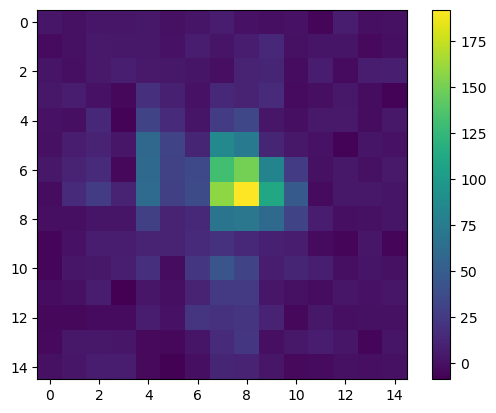

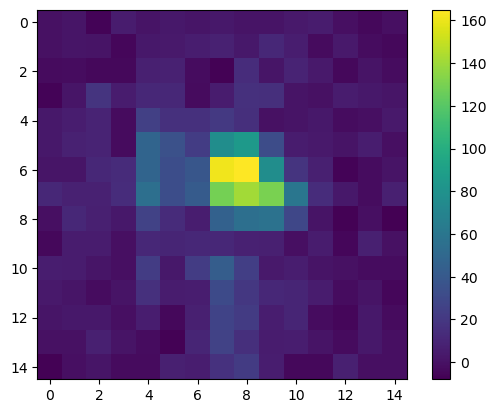

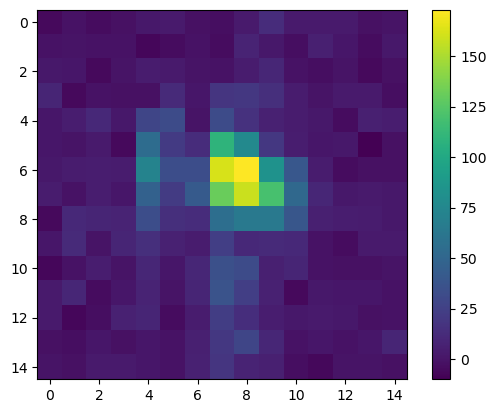

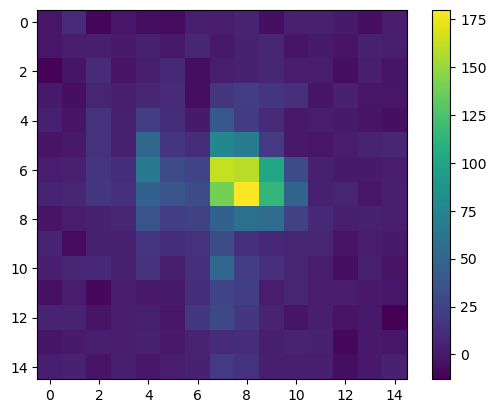

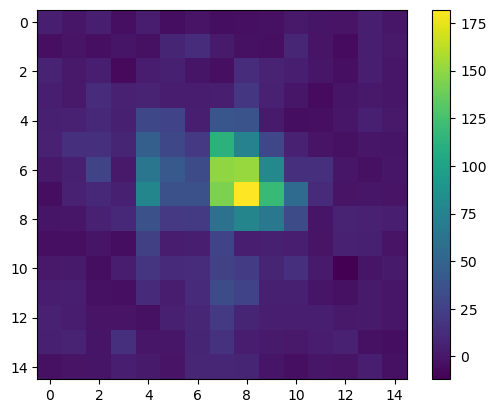

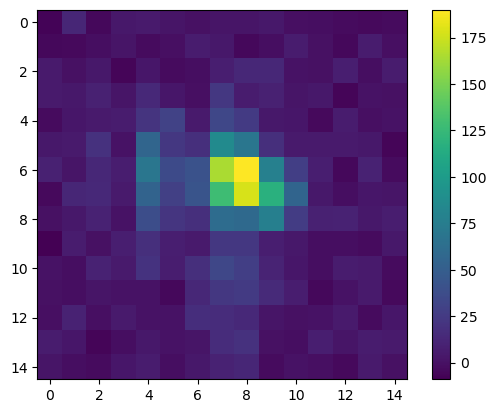

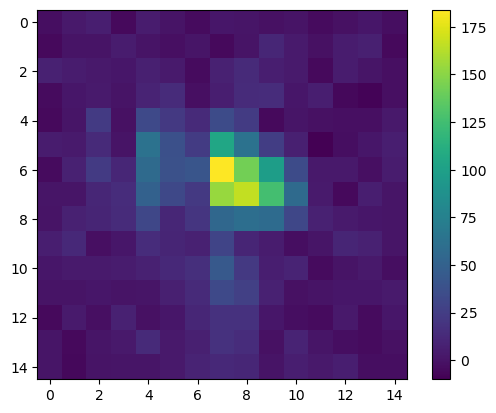

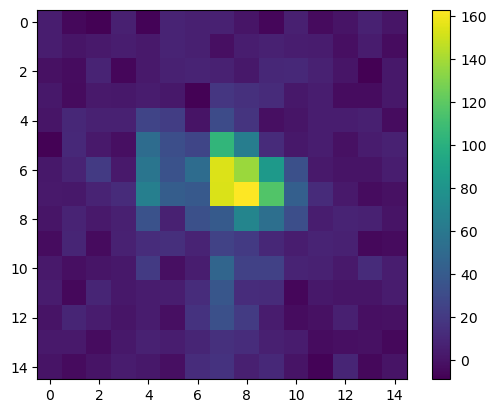

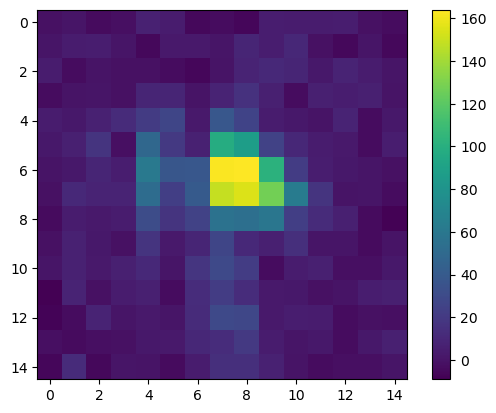

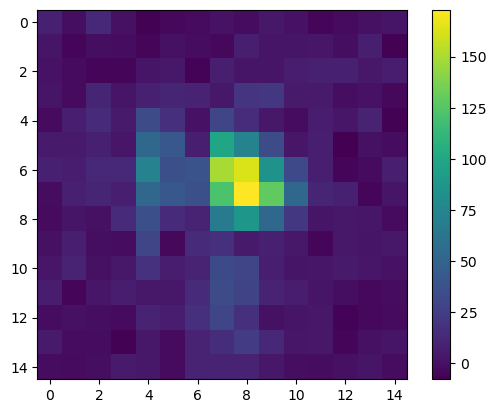

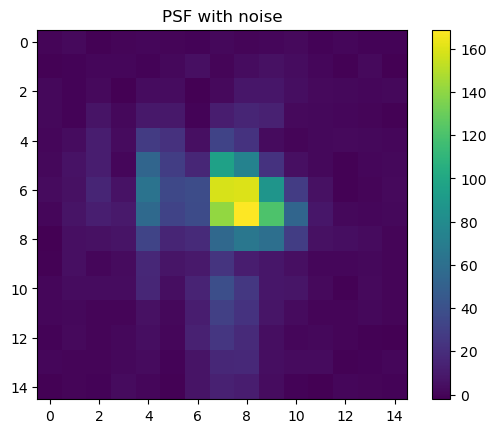

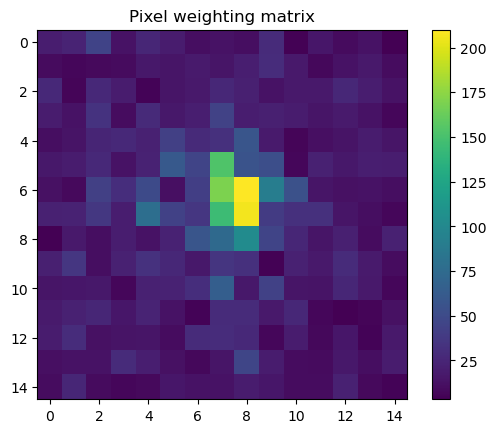

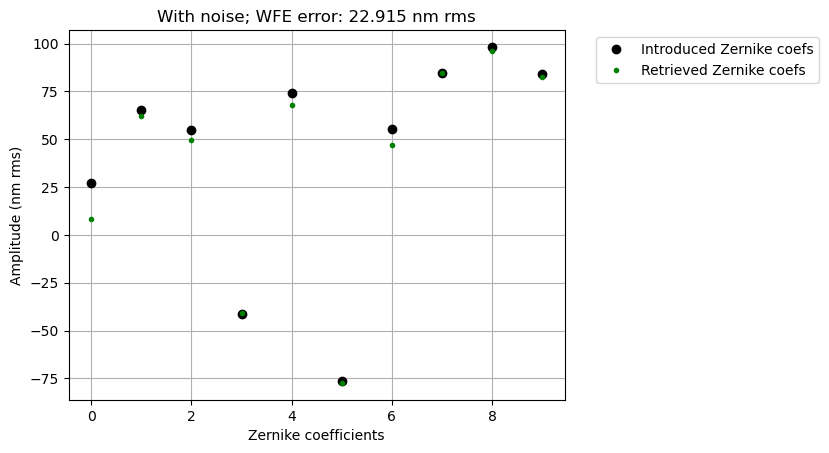

In [7]:
# considering noise
PSF_test = PSFfromCoefs(coefs_0,diversity_OPD)

samples = 10

data_cube = np.zeros((samples,estimator.img_resolution,estimator.img_resolution),dtype=float)

for i in range(samples):
    det.integrate(frame=PSF_test)
    PSF = det.frame
    
    plt.imshow(PSF)
    plt.colorbar()
    plt.show()
    
    data_cube[i,:,:] = PSF
µ
PSF_noisy = data_cube.mean(axis=0)

# PSF_noisy /= np.sum(PSF_noisy)

R_n = data_cube.var(axis=0)

plt.imshow(PSF_noisy)
plt.title("PSF with noise")
plt.colorbar()
plt.show()

plt.imshow(R_n)
plt.title("Pixel weighting matrix")
plt.colorbar()
plt.show()

coefs_1, PSF_1, _ = estimator.Reconstruct(PSF_noisy, R_n=R_n, mode_ids=modes,verbous=False, optimize_norm='sum')

error_analysis(coefs_inp = coefs_0, coefs_out = coefs_1, noise = True, number_modes = number_modes)